In [2]:
import keras.metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn import metrics
import umap
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from IPython.display import Javascript
from nbconvert import HTMLExporter
import time
import os
import tempfile
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



def umap_plot(umap, labels):
    plt.figure(figsize=(12, 8))
    plt.scatter(umap[np.where(labels == 1), 0], umap[np.where(labels == 1), 1], color='g', linewidth=1, alpha=0.8, label='MAIT')
    plt.scatter(umap[np.where(labels == 0), 0], umap[np.where(labels == 0), 1], color='r', linewidth=1, alpha=0.8, label='Non-MAIT')
    plt.legend(loc='best');
    plt.show();

def save_notebook():
    display(
        Javascript("IPython.notebook.save_notebook()"),
        include=['application/javascript']
    )

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)
current_file = 'TAD_serialVAE_classifier.ipynb'

## Set notebook output name here:
output_file = 'TAD_SVAE_local_fullseq_01Norm.html'

# Data Import

In [3]:
np.random.seed(42)

## randomly select ~44k TCRs from MAIT pool - this saves having to import the whole dataset only to subset later.
rng = np.random.default_rng()
files = rng.choice(range(1,98), size=97, replace=False)

## Read in data
data = []
## TODO: write method to save names of files used in training/testing
for i in range(1,98):
    data.append(pd.read_csv("../data/mait/pbert/MAIT_betaSeq_recon_"+str(i)+"_pbert_local.csv", header=None))
mait_loc = pd.concat(data, axis=0, ignore_index=False)

del data
mait_local = mait_loc.to_numpy()
del mait_loc

data = []
## max here is 133
files = rng.choice(range(1,95), size=94, replace=False)
for i in range(1,95):
    data.append(pd.read_csv("../data/tcr_beta/pbert/tcr_beta_seq_"+str(i)+"_pbert_local.csv", header=None))
vdjdb_loc = pd.concat(data)
del data
vdjdb_local = vdjdb_loc.to_numpy()
print(vdjdb_local.shape)
del vdjdb_loc

data = np.append(mait_local, vdjdb_local, axis=0)

labels = np.repeat([1,0], [mait_local.shape[0], vdjdb_local.shape[0]], axis=0)
print("done")

(93856, 1562)
done


In [4]:
print(mait_local.shape)
print(vdjdb_local.shape)
print(mait_local.shape[0] + vdjdb_local.shape[0])
print(data.shape)

print(labels)

unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

(96235, 1562)
(93856, 1562)
190091
(190091, 1562)
[1 1 1 ... 0 0 0]


{0: 93856, 1: 96235}

In [5]:
neg, pos = np.bincount(labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 190091
    Positive: 96235 (50.63% of total)



# Normalization

In [6]:

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

## Center normalization
#mean_val = tf.reduce_mean(train_data)
#train_data = train_data - mean_val
#test_data = test_data - mean_val
#val_data = val_data - mean_val

## Min/Max 0,1 normalization
min_val = tf.reduce_min(data)
max_val = tf.reduce_max(data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
val_data = (val_data - min_val) / (max_val - min_val)
data = (data - min_val) / (max_val - min_val)
### Standardized normalisation (center, scaled)
#train_centered = train_data - mean_val
#test_centered = test_data - mean_val
#min_val = tf.reduce_min(train_data)
#max_val = tf.reduce_max(train_data)
#train_scaled = (train_data - min_val) / (max_val - min_val)
#test_scaled = (test_data - min_val) / (max_val - min_val)
#train_data = (train_centered * train_scaled)
#test_data = (test_centered * test_scaled)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)
val_data = tf.cast(val_data, tf.float32)
print("done")

2022-02-11 10:06:07.877091: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


done


Check transformed data structure

In [7]:
umap_fitter = umap.UMAP()
umap_xy = umap_fitter.fit_transform(data)

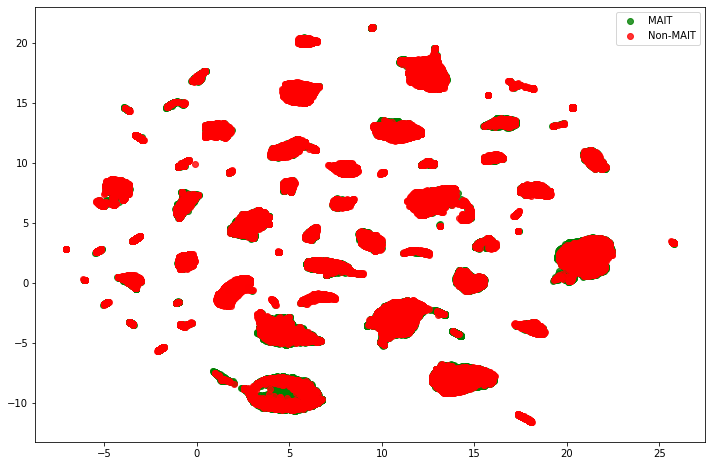

In [8]:
umap_plot(umap_xy, labels)

In [9]:
print("Data object dimensionality \n")
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)

Data object dimensionality 

(121657, 1562)
(38019, 1562)
(30415, 1562)
(121657,)
(38019,)
(30415,)



# Define VAE

In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder
def encoder_model(train_data):
    encoder_inputs = tf.keras.Input(shape=(train_data.shape[1],))
    x = layers.Dense(1024, activation="relu")(encoder_inputs)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    ## these layers should have same dim as last Dense layer.
    z_mean = layers.Dense(256, name="z_mean")(x)
    z_log_var = layers.Dense(256, name="z_log_var")(x)

    # Sample from these distributions
    z = Sampling()([z_mean, z_log_var])
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

## Mirror image of encoder
def decoder_model(train_data):
    latent_inputs = tf.keras.Input(shape=(256,))
    x = layers.Dense(512, activation="relu")(latent_inputs)
    x = layers.Dense(1024, activation="relu")(x)
    decoder_outputs = layers.Dense(train_data.shape[1], activation="relu")(x)
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

done


In [11]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
print("done")

done


In [12]:
encoder = encoder_model(train_data)
decoder = decoder_model(train_data)


vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

In [ ]:
## Is this wise for a large graph?
##tf.keras.utils.plot_model(vae, show_shapes=True)

In [13]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Maybe try adding an early stopping function?
earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="loss",
                                        mode ="min", patience = 5,
                                        restore_best_weights = True)

# Fit the model to the training set
history = vae.fit(train_data, train_data,
          epochs=80,
          batch_size=256,
          shuffle=True,
          callbacks= [earlystopping, lr_scheduler])

Epoch 1/80
476/476 [==============================] - 33s 67ms/step - loss: 0.8502 - reconstruction_loss: 0.8344 - kl_loss: 0.0158 - lr: 1.0000e-04
Epoch 2/80
476/476 [==============================] - 30s 63ms/step - loss: 0.6961 - reconstruction_loss: 0.6877 - kl_loss: 0.0083 - lr: 1.0000e-04
Epoch 3/80
476/476 [==============================] - 30s 63ms/step - loss: 0.6674 - reconstruction_loss: 0.6638 - kl_loss: 0.0036 - lr: 1.0000e-04
Epoch 4/80
476/476 [==============================] - 30s 62ms/step - loss: 0.6508 - reconstruction_loss: 0.6495 - kl_loss: 0.0013 - lr: 1.0000e-04
Epoch 5/80
476/476 [==============================] - 30s 63ms/step - loss: 0.6415 - reconstruction_loss: 0.6409 - kl_loss: 5.3128e-04 - lr: 1.0000e-04
Epoch 6/80
476/476 [==============================] - 31s 65ms/step - loss: 0.6356 - reconstruction_loss: 0.6354 - kl_loss: 2.3501e-04 - lr: 1.0000e-04
Epoch 7/80
476/476 [==============================] - 30s 63ms/step - loss: 0.6316 - reconstruction_loss

In [15]:
print("Final learning rate =", tf.keras.backend.eval(vae.optimizer.lr))

Final learning rate = 2.0241923e-06


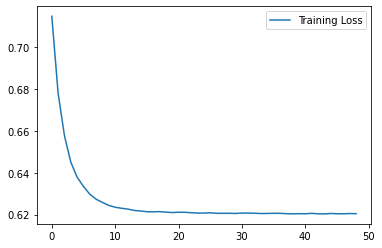

In [16]:
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()

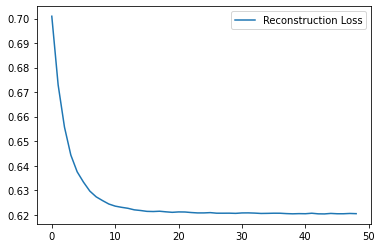

In [17]:
plt.plot(history.history["reconstruction_loss"], label="Reconstruction Loss")
plt.legend()

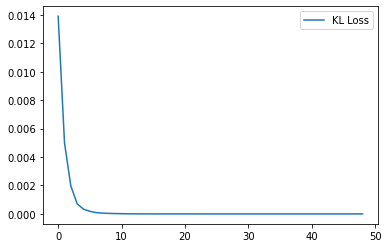

In [18]:
plt.plot(history.history["kl_loss"], label="KL Loss")
plt.legend()



## Check Encoding of MAIT & non-MAIT

In [19]:
#latent_var = keras.Sequential()
#latent_var.add(vae.layers[0])
#latent_var.add(vae.layers[1])
#latent_var.add(vae.layers[2])
test_pred = vae.encoder.predict(test_data)
test_latent_vars = test_pred[2]
val_pred = vae.encoder.predict(val_data)
val_latent_vars = val_pred[2]

In [20]:
#test_latent_vars = latent_var.predict(test_data)

#val_latent_vars = latent_var.predict(val_data)
print(test_latent_vars.shape)

(38019, 256)


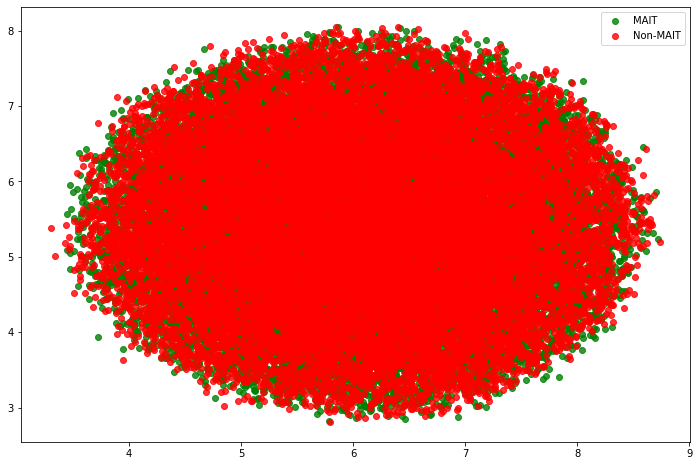

In [21]:
#umap_fitter = umap.UMAP()
#test_latent_umap = umap_fitter(test_latent_vars)
test_latent_umap = umap.UMAP.fit_transform(self=umap.UMAP(),X=test_latent_vars)
umap_plot(test_latent_umap, test_labels)

# Classifier

Train logistic classifier on latent variables

In [22]:
clf = LogisticRegression().fit(test_latent_vars, test_labels)
pred_labels = clf.predict(val_latent_vars)

print(metrics.confusion_matrix(val_labels, pred_labels))
print (metrics.classification_report(val_labels, pred_labels))
print (metrics.accuracy_score(val_labels, pred_labels))


[[6612 8282]
 [6755 8766]]
              precision    recall  f1-score   support

           0       0.49      0.44      0.47     14894
           1       0.51      0.56      0.54     15521

    accuracy                           0.51     30415
   macro avg       0.50      0.50      0.50     30415
weighted avg       0.50      0.51      0.50     30415

0.5056057866184448


In [ ]:
save_notebook()
time.sleep(3)
output_HTML(current_file, output_file)